# Project2: Anomaly Detection for Exotic Event Identification at the Large Hadron Collider 





Designing an anomaly detection algorithm which is trained on the SM dataset and which can be used to flag up interesting (exotic) events from the BSM physics models.

For this I have built an autoencoder trained on the event llevel variables 'MET; METphi' and the kindematics of the particle level objects.

In [1]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
# Standard import(s)
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
# Keras import(s)
#if float(tf.__version__[:3])>2.8:
#from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import BatchNormalization,Input, Dense, Dropout, Flatten, Reshape, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Lambda, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

# Keras import(s)
#if float(tf.__version__[:3])>2.8:
#    from tensorflow.keras.utils import plot_model
#else:
#    from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

In [10]:
fname = 'background_chan2b_7.8.csv'
delims = ','

In [11]:
with open(fname, 'r') as file:
    reader = csv.reader(file,delimiter = delims)
    row_count = sum(1 for row in reader)
    file.close()

In [12]:




vals = np.zeros((row_count,39))
with open(fname, 'r') as file:
    reader = csv.reader(file,delimiter = delims)
    
    
    count = 0
   
    
    for row in reader:
        
        for i in range(len(row)):
            row[i] = row[i].split(';')
        
        
       
        # Convert each row to a numpy array
        row_array = np.array(np.concatenate(row))[:-1]
        no_el = np.count_nonzero(row_array == 'e-') +np.count_nonzero(row_array == 'e+')
        no_ph = np.count_nonzero(row_array == 'g')
        no_mu = np.count_nonzero(row_array == 'm-') + np.count_nonzero(row_array == 'm+')
        no_je = np.count_nonzero(row_array == 'j')
        no_bj = np.count_nonzero(row_array == 'b')
        split = np.array(np.array_split(row_array, len(row_array)/5))
        #print(split[1:,1:]) #.sort(key=lambda x: x.max(), reverse=True))
        sortE = np.array(sorted(split[1:,1:], key=lambda x: x[0], reverse=True))
        MET = float(split[0,3])
        
        METphi = float(split[0,4])
        logMET = np.log(MET)
        trunc = sortE[:8].astype(float) 
        trunc[:,0] = np.log(trunc[:,0] )
        trunc[:,1] = np.log(trunc[:,1] )
        
     
        addzeros = np.zeros(4)
        while len(trunc) < 8:
            trunc = np.vstack([trunc,addzeros])
        trunc = trunc.flatten()
        array = np.array([no_el,no_mu, no_je, no_bj,no_ph,logMET,METphi])
        arr = np.concatenate((array,trunc))
        vals[count] = arr
      
        count += 1
        

        
    
   

     
    

In [13]:

df = pd.DataFrame(vals)
scaler = preprocessing.MinMaxScaler()
dfscaled = pd.DataFrame(scaler.fit_transform(df),columns = df.columns)

In [14]:
print(dfscaled)
df_shuffled = np.random.permutation(df)
X_train, X_test = train_test_split(df_shuffled, test_size=0.2)


         0    1         2         3    4         5         6         7   \
0       0.5  0.0  0.636364  0.000000  0.0  0.203159  0.027910  0.339558   
1       0.0  0.5  0.090909  0.000000  0.0  0.205682  0.812250  0.528321   
2       0.0  0.5  0.090909  0.166667  0.0  0.268953  0.312370  0.273646   
3       0.0  0.5  0.181818  0.000000  0.0  0.124949  0.326246  0.712602   
4       0.0  0.5  0.090909  0.166667  0.0  0.215575  0.336637  0.344780   
...     ...  ...       ...       ...  ...       ...       ...       ...   
340263  0.0  0.5  0.090909  0.166667  0.0  0.077135  0.316395  0.341184   
340264  0.0  0.5  0.181818  0.166667  0.0  0.045515  0.584313  0.314045   
340265  0.0  0.5  0.363636  0.166667  0.0  0.544417  0.628054  0.369713   
340266  0.0  0.5  0.272727  0.000000  0.0  0.451776  0.364810  0.682032   
340267  0.0  0.5  0.272727  0.000000  0.0  0.220569  0.737133  0.362787   

              8         9   ...        29        30        31        32  \
0       0.332320  0.6500

In [15]:
#Define auto encoder model

input_dim = X_train.shape[1]

encoding_dim = 32
input_layer = Input(shape=(input_dim, ))
x = Dense(encoding_dim, activation="relu")(input_layer)
x = Dense(100, activation="relu")(x)
x = Dense(50, activation="relu")(x)
x = Dense(25, activation="relu")(x)
#x = Dense(2, activation="relu")(x)


In [16]:
#x = Dense(4, activation="relu")(x)
x = Dense(25, activation="relu")(x)
x = Dense(50, activation="relu")(x)
x = Dense(100, activation="relu")(x)
decoder = Dense(input_dim, activation="sigmoid")(x)
autoencoder = Model(input_layer, decoder)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 39)]              0         
                                                                 
 dense (Dense)               (None, 32)                1280      
                                                                 
 dense_1 (Dense)             (None, 100)               3300      
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 25)                1275      
                                                                 
 dense_4 (Dense)             (None, 25)                650       
                                                                 
 dense_5 (Dense)             (None, 50)                1300  

In [17]:
"""early_stop = EarlyStopping( 
    monitor='val_loss',
    patience=5,
)
"""

"early_stop = EarlyStopping( \n    monitor='val_loss',\n    patience=5,\n)\n"

In [18]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# train the autoencoder
history =autoencoder.fit(X_train, X_train, epochs=30, batch_size=32, validation_data=(X_test, X_test))
    

Train on 272214 samples, validate on 68054 samples
Epoch 1/30
124448/272214 [============>.................] - ETA: 14s - loss: 27.8553

KeyboardInterrupt: 

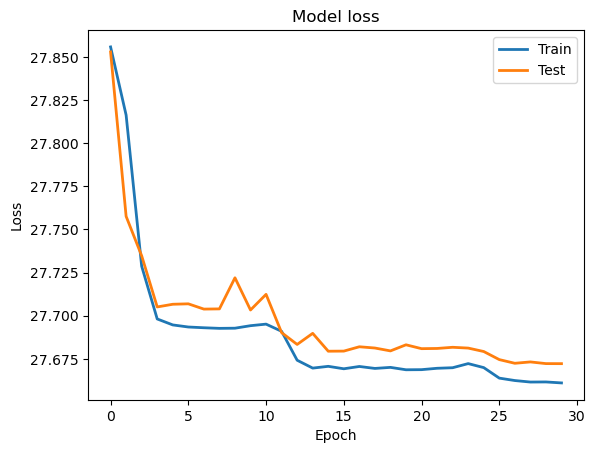

In [ ]:
plt.plot(history.history['loss'], linewidth=2, label='Train')
plt.plot(history.history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
#plt.ylim(ymin=0.70,ymax=1)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
# use the autoencoder to make predictions on the test set
X_test_predictions = autoencoder.predict(X_test)

# calculate the mean absolute error between the predictions and the true values
mae = mean_absolute_error(X_test, X_test_predictions)
print("Mean Absolute Error: ", mae)

# flag any samples with a large reconstruction error as anomalies
anomalies = np.where(np.abs(X_test - X_test_predictions) > mae*3)
print("Anomalies: ", anomalies)

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Mean Absolute Error:  2.9503750720138964
Anomalies:  (array([    0,     0,     0, ..., 68053, 68053, 68053], dtype=int64), array([ 5,  7,  8, ..., 16, 19, 20], dtype=int64))


In [ ]:

reconstruction_error = autoencoder.evaluate(X_new, X_new, verbose=0)
if reconstruction_error > threshold:
    print("Anomaly detected")
else:
    print("No anomaly detected")

NameError: name 'X_new' is not defined